In [109]:
import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
from sklearn import metrics
import matplotlib.pyplot as plt
from afinn import Afinn

# Importing Data

In [110]:
#Training dataset loaded in
train = pd.read_csv("train.csv")

# test data/Validation
test = pd.read_csv("test.csv")

In [111]:
print(test.head())

   label                                              tweet
0      1  == Arabs are committing genocide in Iraq, but ...
1      1  DJ Robinson is gay as hell! he sucks his dick ...
2      1               :Fuck off, you anti-semitic cunt.  |
3      1  How dare you vandalize that page about the HMS...
4      1  ::No, he is an arrogant, self serving, immatur...


# NLTK Download

In [112]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Junayid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Junayid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Junayid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Cleaning Function / Data Pre-Processing

In [113]:
def clean_tweet(df):
    df['tweet'].dropna(inplace=True)#Removing empty entries
    df['tweet_temp'] = [entry.lower() for entry in df ['tweet']] #Lowercase
    df['tweet_temp'] = [word_tokenize(entry) for entry in df['tweet_temp']] # Tokenisation
    
#Part of speech tagging, to highlight types of words, nouns adjectives etc
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['R'] = wn.ADV
    tag_map['V'] = wn.VERB
    tag_map['J'] = wn.ADJ
    
    for index,entry in enumerate(df['tweet_temp']):
        final_words = [] #Ampty list which will be assigined cleaned tweets
        word_Lemmatized = WordNetLemmatizer()#Calling Lemmatiser
        
        for word, tag in pos_tag(entry):
            if word not in stopwords.words('english') and word.isalpha():
                word_final = word_Lemmatized.lemmatize(word, tag_map[tag[0]]) # Performing lemmatisation of words that if statements
                final_words.append(word_final)
        df.loc[index, 'clean_tweet'] = str(final_words) # Implement all cleaned tweets in to DF
    
    del df['tweet_temp']#no need for this initial DF.

In [114]:
clean_tweet(train)
clean_tweet(test)

#Running clean function on datasets

In [115]:
test['clean_tweet'].head()

0    ['arab', 'commit', 'genocide', 'iraq', 'protes...
1    ['dj', 'robinson', 'gay', 'hell', 'suck', 'dic...
2                                     ['fuck', 'cunt']
3    ['dare', 'vandalize', 'page', 'hm', 'beagle', ...
4    ['arrogant', 'self', 'serving', 'immature', 'i...
Name: clean_tweet, dtype: object

# Test Train Splitting

In [116]:
train_x = train['clean_tweet']
test_x = test['clean_tweet']
train_y = train['label']
test_y = test['label']

#Assinging X and Y varaibles accordingly

In [117]:
print(train_x.head())

0    ['fuck', 'nazi', 'propaganda', 'odpierdalcie',...
1    ['really', 'sure', 'issue', 'name', 'rise', 'b...
2    ['since', 'user', 'page', 'say', 'want', 'guy'...
3    ['awesome', 'wikipedian', 'shit', 'droppings',...
4    ['fuck', 'u', 'useless', 'bot', 'fuck', 'u', '...
Name: clean_tweet, dtype: object


In [118]:
print(train_y.head())

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64


In [119]:
train['label'].value_counts()

0    27816
1    15052
Name: label, dtype: int64

In [120]:
test['label'].value_counts()

0    14778
1     6332
Name: label, dtype: int64

# TFIDF Vectorisation

In [121]:
vectorizer = TfidfVectorizer(max_features=5000)

In [122]:
vectorizer.fit(train['clean_tweet'])
vectorizer.fit(test['clean_tweet'])
train_x_vec = vectorizer.transform(train_x)
test_x_vec = vectorizer.transform(test_x)

# SVM Application 

In [123]:
SVM = svm.SVC(kernel = 'linear',class_weight='balanced',C=2,random_state=64,)
SVM.fit(test_x_vec, test_y)
predictions_SVM = SVM.predict(test_x_vec)


print("SVM Accuracy Score -> ", accuracy_score(test_y, predictions_SVM) * 100)
print("SVM Precision Score -> ", precision_score(test_y, predictions_SVM) * 100)
print("SVM Recall Score -> ", recall_score(test_y, predictions_SVM) * 100)
print("SVM F1 Score -> ", f1_score(test_y, predictions_SVM) * 100)
print("SVM Confusion Matrix ->")
confusion_matrix(test_y, predictions_SVM)

SVM Accuracy Score ->  93.78493604926575
SVM Precision Score ->  85.70412517780939
SVM Recall Score ->  95.15161086544536
SVM F1 Score ->  90.1811106121838
SVM Confusion Matrix ->


array([[13773,  1005],
       [  307,  6025]], dtype=int64)

In [124]:
df = pd.DataFrame(metrics.confusion_matrix(test_y, predictions_SVM), index=['non','abuse'], columns=['non','abuse'])
df

,non,abuse
non,13773,1005
abuse,307,6025


In [125]:
print(classification_report(test_y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     14778
           1       0.86      0.95      0.90      6332

    accuracy                           0.94     21110
   macro avg       0.92      0.94      0.93     21110
weighted avg       0.94      0.94      0.94     21110



# Applying SVM on Validation data

In [126]:
test_vec = vectorizer.transform(test['clean_tweet'])

In [127]:
predictions_SVM = SVM.predict(test_vec)

In [128]:
test['SVM_Model'] = predictions_SVM

# SVM Visualisation

### Examining general results on validation data for SVM Model

[Text(0, 0, 'Non Abusive'), Text(1, 0, 'Abusive')]

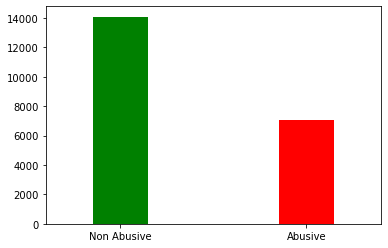

In [129]:
plot_df = test.groupby(['SVM_Model']).size().reset_index(name='count')
ax = plot_df['count'].plot(kind='bar', width=0.3, color = ["green","red"])
ax.set_xticklabels(labels=['Non Abusive', 'Abusive'], rotation=0, )

In [130]:
test['SVM_Model'].value_counts()

0    14080
1     7030
Name: SVM_Model, dtype: int64

In [131]:
train.head()

,label,tweet,clean_tweet
0,1,FUCK OF NAZI PROPAGANDA\r\nodpierdalcie sie je...,"['fuck', 'nazi', 'propaganda', 'odpierdalcie',..."
1,1,Not really sure what the issue is here \r\n\r\...,"['really', 'sure', 'issue', 'name', 'rise', 'b..."
2,1,"Since this is MY user page, I can say what I w...","['since', 'user', 'page', 'say', 'want', 'guy'..."
3,1,"""\r\n\r\n You Are an Awesome wikipedian \r\n\r...","['awesome', 'wikipedian', 'shit', 'droppings',..."
4,1,FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT ...,"['fuck', 'u', 'useless', 'bot', 'fuck', 'u', '..."


# AFINN Lexicon

In [132]:
af = Afinn()

## Creating classification function

In [133]:
def sentimentgraph(sentence):
    sentence = sentence[1:-1].replace(',', '').replace('\'', '')
    score = af.score(sentence)# Calls AFINN polarity score metric
    if score >= 0:
        return 1
    else:
        return -1
#Returns only classificaitions 

def sentimentscore(sentence):
    sentence = sentence[1:-1].replace(',', '').replace('\'', '')
    score = af.score(sentence)
    return score

#Used to generate pure sentiment

In [134]:
test['AFINN_Lexicon'] = test['clean_tweet'].apply(sentimentgraph)

In [135]:
test['Sentiment_Score'] = test['clean_tweet'].apply(sentimentscore)

# Examining AFINN Lexicon results on Validation dataset

[Text(0, 0, 'Non Abusive'), Text(1, 0, 'Abusive')]

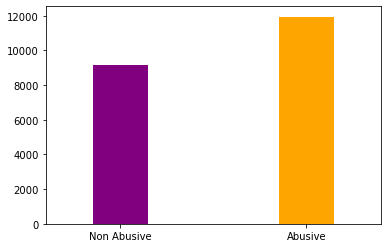

In [136]:
plot_df = test.groupby(['AFINN_Lexicon']).size().reset_index(name='count')
ax = plot_df['count'].plot(kind='bar', width=0.3, color =["purple","orange"])
ax.set_xticklabels(labels=['Non Abusive', 'Abusive'], rotation=0)

In [137]:
test['AFINN_Lexicon'].value_counts()

 1    11940
-1     9170
Name: AFINN_Lexicon, dtype: int64

# Calling Pre-Made TFIDF Lexicon

In [138]:
gen_lexicon = pd.read_csv('lexicon.csv')

In [139]:
positive_words_list = gen_lexicon['Positive'].tolist()
negative_words_list = gen_lexicon['Negative'].tolist()

In [140]:
print (positive_words_list)

['tip', 'program', 'leftist', 'ready', 'retired', 'stupidity', 'isi', 'leviwood', 'though', 'price', 'liberal', 'radical', 'keep', 'racing', 'legitimate', 'answer', 'smart', 'skin', 'connectcut', 'sickness', 'defect', 'stability', 'property', 'bureaucrat', 'tyrone', 'sharp', 'army', 'possessed', 'want', 'drive', 'invite', 'bunnysmind', 'pit', 'muslims', 'room', 'cau', 'life', 'downtown', 'recognize', 'identifies', 'arm', 'story', 'deceptive', 'body', 'college', 'bludgeon', 'american', 'historyrepeatsitself', 'jarrett', 'immoral', 'evidently', 'word', 'aureliano', 'rid', 'attention', 'source', 'mental', 'degradation', 'appropriate', 'attend', 'math', 'commit', 'vote', 'conflict', 'group', 'btw', 'pc', 'beast', 'potential', 'road', 'regard', 'blacklivesmatter', 'ape', 'predate', 'rather', 'davidhartwell', 'endpcinamerica', 'nearly', 'archangeljack', 'witch', 'selective', 'refugee', 'critically', 'kdlnola', 'promise', 'store', 'manchurian', 'ratherbefishing', 'jesus', 'survive', 'joesnow'

### Creating Classification function

In [141]:
def TFIDF_graph(sentence):
    sentence = sentence[1:-1].replace(',', '').replace('\'', '')
    words = sentence.split(' ')
    score = 0
    for word in words:
        if word in positive_words_list: # HIGHER SCORE MEANS LESS ABUSIVE
            score += 1
        elif word in negative_words_list: #LOWER SCORE MEANS MORE ABUSIVE
            score -= 1
    if score >= 0:
        return 1
    else:
        return -1

In [142]:
test['TFIDF_Lexicon'] = test['clean_tweet'].apply(TFIDF_graph)

# Validation testing of TFIDF Lexicon

[Text(0, 0, 'Non Abusive'), Text(1, 0, 'Abusive')]

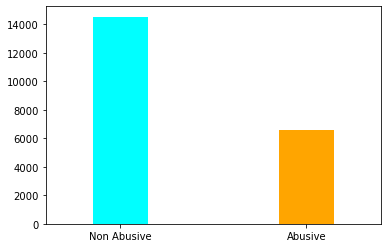

In [143]:
plot_df = test.groupby(['TFIDF_Lexicon']).size().reset_index(name='count')
ax = plot_df['count'].plot(kind='bar', width=0.3, color =["cyan","orange"])
ax.set_xticklabels(labels=['Non Abusive', 'Abusive'], rotation=0)

In [144]:
test['TFIDF_Lexicon'].value_counts()

-1    14545
 1     6565
Name: TFIDF_Lexicon, dtype: int64

# Twitter API

In [145]:
import tweepy

### Developer Keys

In [146]:
consumer_key = "0vvc4ChRMx3fRCxDdmIpfSAKc"
consumer_secret = "zFeKJOhf6Y4zw5e5PcyI4GaLE2aiy4U0K68I7tm4OmxAwJIgKT"
access_token = "1109999346-YmM6wO5s44Vez5dBuEnYB35dxbDfHWxsxoBxtdD"
access_token_secret = "rGa0OOHs1sO3k3s1D03xYre5SG6UIMfjkg3jGtauplrg5"

In [147]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth) 

# Fetching Tweets

### Queary based search

In [148]:
query = 'Football'
max_tweet = 5

searched_tweets = api.search(q=query, count=max_tweet, tweet_mode='extended')
tweets = []

for tweet in searched_tweets:
    tweets.append(tweet.full_text)

tweets_df = pd.DataFrame(tweets, columns=['tweet'])

### TImeline based search

In [149]:
#public_tweets = api.home_timeline()

#tweets = []

#for tweet in public_tweets:
#  tweets.append(tweet.text)

#tweets_df = pd.DataFrame(tweets, columns=['tweet'])

In [150]:
print(tweets)

['Colt Brennan and Hawaii used to have you up late watching their games. Then had me playing NCAA football with Hawaii even chose to go there with one of my created players. RIP to a college football legend.', "RT @MichealAyebs: Your a football fan and lover and you don't have a television to watch your football from, @ApplianceWUg has got you UHD…", 'RT @BuryFCBoysGirls: Our girls #weetabixwildcats sessions are back in full swing\n\nAged 5-11 want to get involved with football? Get in touc…', "RT @JoeEdwards_Star: Around 4,500 tickets are going on sale for Wolves' final game of the season against Manchester United at Molineux. Tho…", '@AdamSchefter Loved watching him play. He put Hawaii football on the map. R.I.P. Colt! 🙏🏼']


### Cleaning Tweets

In [151]:
clean_tweet(tweets_df)

# Applying SVM 

In [152]:
tweets_df_vec = vectorizer.transform(tweets_df['clean_tweet'])

In [153]:
predictions_SVM = SVM.predict(tweets_df_vec)

In [154]:
tweets_df['SVM_Model'] = predictions_SVM

# Applying AFINN Lexicon

In [155]:
tweets_df['AFINN_Lexicon'] = tweets_df['clean_tweet'].apply(sentimentgraph)

In [156]:
tweets_df.head()

,tweet,clean_tweet,SVM_Model,AFINN_Lexicon
0,Colt Brennan and Hawaii used to have you up la...,"['colt', 'brennan', 'hawaii', 'use', 'late', '...",0,1
1,RT @MichealAyebs: Your a football fan and love...,"['rt', 'michealayebs', 'football', 'fan', 'lov...",0,1
2,RT @BuryFCBoysGirls: Our girls #weetabixwildca...,"['rt', 'buryfcboysgirls', 'girl', 'weetabixwil...",0,1
3,"RT @JoeEdwards_Star: Around 4,500 tickets are ...","['rt', 'around', 'ticket', 'go', 'sale', 'wolf...",0,1
4,@AdamSchefter Loved watching him play. He put ...,"['adamschefter', 'love', 'watch', 'play', 'put...",0,1


# Applying TFIDF Lexicon

In [157]:
tweets_df['TFIDF_Lexicon'] = tweets_df['clean_tweet'].apply(TFIDF_graph)

In [158]:
tweets_df.head()

,tweet,clean_tweet,SVM_Model,AFINN_Lexicon,TFIDF_Lexicon
0,Colt Brennan and Hawaii used to have you up la...,"['colt', 'brennan', 'hawaii', 'use', 'late', '...",0,1,-1
1,RT @MichealAyebs: Your a football fan and love...,"['rt', 'michealayebs', 'football', 'fan', 'lov...",0,1,-1
2,RT @BuryFCBoysGirls: Our girls #weetabixwildca...,"['rt', 'buryfcboysgirls', 'girl', 'weetabixwil...",0,1,-1
3,"RT @JoeEdwards_Star: Around 4,500 tickets are ...","['rt', 'around', 'ticket', 'go', 'sale', 'wolf...",0,1,-1
4,@AdamSchefter Loved watching him play. He put ...,"['adamschefter', 'love', 'watch', 'play', 'put...",0,1,-1


## AFINN Polarity/Sentiment Scores

In [159]:
tweets_df['Sentiment score'] = tweets_df['clean_tweet'].apply(sentimentscore)

In [160]:
tweets_df.head()

,tweet,clean_tweet,SVM_Model,AFINN_Lexicon,TFIDF_Lexicon,Sentiment score
0,Colt Brennan and Hawaii used to have you up la...,"['colt', 'brennan', 'hawaii', 'use', 'late', '...",0,1,-1,0.0
1,RT @MichealAyebs: Your a football fan and love...,"['rt', 'michealayebs', 'football', 'fan', 'lov...",0,1,-1,3.0
2,RT @BuryFCBoysGirls: Our girls #weetabixwildca...,"['rt', 'buryfcboysgirls', 'girl', 'weetabixwil...",0,1,-1,1.0
3,"RT @JoeEdwards_Star: Around 4,500 tickets are ...","['rt', 'around', 'ticket', 'go', 'sale', 'wolf...",0,1,-1,0.0
4,@AdamSchefter Loved watching him play. He put ...,"['adamschefter', 'love', 'watch', 'play', 'put...",0,1,-1,3.0


### Printing results to a CSV file

In [161]:
tweets_df.to_csv("result.csv", encoding='utf-8')